In [126]:
import xarray as xr
import glob
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
from scipy import interpolate

#YEAR TO PROCESS
yeart='2008'
montht='01'

#DATE REF
date_1 = datetime.datetime.strptime('01/01/1950', "%m/%d/%Y")

#OCCIPUT SDL INTERPOLATION
OCCI = '/home1/ballycotton/DATA/PIRATE/SDL_INTERP/'+yeart+'/'
patho = glob.glob(os.path.join(OCCI+'*'+montht+'.nc'))

#MIT PROFILES
MIP = '/home1/ballycotton/DATA/MIT-SDL/'
pathm = glob.glob(os.path.join(MIP+'*.nc'))
pathm.sort()

#OPEN
OCC=xr.open_dataset(patho[0],decode_times=False,mask_and_scale=True)
MIT=xr.open_mfdataset(pathm,decode_times=False,mask_and_scale=True)
#JULD
MIT=MIT.assign(prof_juld = MIT.prof_date - 712224)

#GEOSUBSET MIT
MIT=MIT.where((MIT.prof_lat>20) & (MIT.prof_lat<45) & (MIT.prof_lon>-85) & (MIT.prof_lon<-30),drop=True)

#REMOVE FIRST LEVEL (0m)
OCC=OCC.where(OCC.STANDARD_LEVELS<0,drop=True)
# ALIGN VARIABLES ALONG ONE DIMENSION 
OCC['A']=OCC.JULD.min(dim='N_LEVELS')
OCC['B']=OCC.STATION_IDENTIFIER.min(dim='N_LEVELS')
OCC['C']=OCC.LATITUDE.min(dim='N_LEVELS')
OCC['D']=OCC.LONGITUDE.min(dim='N_LEVELS')
OCC=OCC.drop(['JULD','STATION_IDENTIFIER','LATITUDE','LONGITUDE'])
OCC=OCC.rename({'A':'JULD','B':'STATION_IDENTIFIER','C':'LATITUDE','D':'LONGITUDE'})
print OCC,MIT

<xarray.Dataset>
Dimensions:             (N_LEVELS: 299, N_MEMBER: 50, N_OBS: 122)
Dimensions without coordinates: N_LEVELS, N_MEMBER, N_OBS
Data variables:
    STANDARD_LEVELS     (N_LEVELS) float64 -5.0 -10.0 -15.0 -20.0 -25.0 ...
    POTM_Hx             (N_MEMBER, N_OBS, N_LEVELS) float64 17.67 17.67 ...
    TEMP_OBS            (N_OBS, N_LEVELS) float64 18.16 18.16 18.15 18.15 ...
    CYCLE_NUMBER        (N_OBS, N_LEVELS) float64 116.0 116.0 116.0 116.0 ...
    POTM_OBS            (N_OBS, N_LEVELS) float64 18.15 18.15 18.15 18.15 ...
    PSAL_OBS            (N_OBS, N_LEVELS) float64 36.23 36.23 36.23 36.23 ...
    PSAL_Hx             (N_MEMBER, N_OBS, N_LEVELS) float64 35.91 35.91 ...
    JULD                (N_OBS) float64 2.118e+04 2.118e+04 2.118e+04 ...
    STATION_IDENTIFIER  (N_OBS) object '4900525 ' '4900800 ' '4900789 ' ...
    LATITUDE            (N_OBS) float64 39.15 20.8 27.12 28.3 41.95 28.06 ...
    LONGITUDE           (N_OBS) float64 -39.93 -53.74 -51.07 -76.28 -53.14 

In [127]:
#MIT MATCHING LOOKUP ARRAY
MITS= xr.Dataset({'PLATFORM_NUMBER': (['JULD'],  MIT.prof_descr.astype('int')),
                'LATITUDE': (['JULD'], MIT.prof_lat),
                'LONGITUDE': (['JULD'], MIT.prof_lon),
                'TEMP': (['JULD','N_LEVELS'], MIT.prof_TeccoV4R2),
                'PSAL': (['JULD','N_LEVELS'], MIT.prof_SeccoV4R2),      
                'DEPH': (['JULD','N_LEVELS'], MIT.prof_depth),                
                },
                 coords={'JULD': MIT.prof_juld.values})

In [128]:
OCC['FIND']= xr.DataArray(np.zeros(len(OCC.N_OBS))+1,dims= {'N_OBS'})
OCC['TEMP_MIT'] = xr.DataArray(np.zeros([len(OCC.N_OBS),299]),dims= {'N_OBS','N_LEVELS'})
OCC['PSAL_MIT'] = xr.DataArray(np.zeros([len(OCC.N_OBS),299]),dims= {'N_OBS','N_LEVELS'})

In [129]:
for i in OCC.N_OBS.values :
    A1=MITS.where(MITS.PLATFORM_NUMBER.isin([int(OCC.STATION_IDENTIFIER[i].values)]),drop=True)        
    A1=A1.sortby(A1.JULD)
    if (len(A1.JULD)>0):             
        A2=A1.sel(JULD=[OCC.JULD[i].values],method='nearest')        
        if(abs(A2.JULD.values-OCC.JULD[i].values)<0.1):
            #INTERPOLATE ISAS PROFILE ON SDT LEVEL            
            ft = interpolate.interp1d(A2.DEPH[0,:], A2.TEMP[0,:])
            fs = interpolate.interp1d(A2.DEPH[0,:], A2.PSAL[0,:])
            OCC.TEMP_MIT[i,:] = ft(-OCC.STANDARD_LEVELS.values)
            OCC.PSAL_MIT[i,:] = fs(-OCC.STANDARD_LEVELS.values)           
    else:
        OCC.FIND[i]=0        
OCC=OCC.where(OCC.FIND==1,drop=True)        
OCC['STANDARD_LEVELS'] = OCC['STANDARD_LEVELS'].isel(N_OBS=0)
OCC=OCC.drop('FIND')

<IPython.core.display.Javascript object>


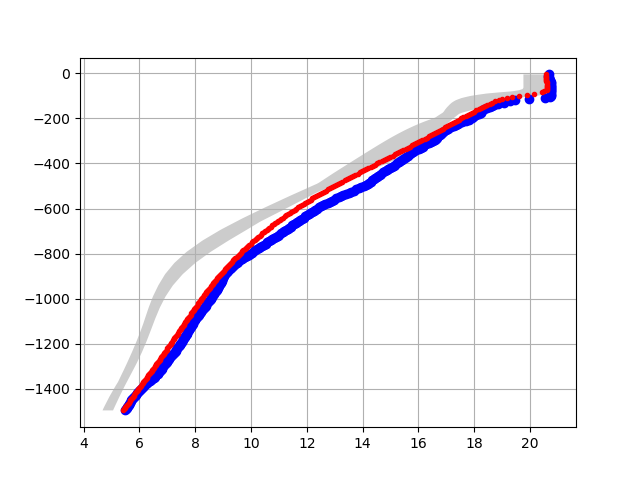

In [130]:
%matplotlib notebook
indx=84
plt.grid(True)
plt.plot(OCC.POTM_OBS[indx,:],OCC.STANDARD_LEVELS,'bo')
plt.plot(OCC.TEMP_MIT[indx,:],OCC.STANDARD_LEVELS,'r.')
plt.fill_betweenx(OCC.STANDARD_LEVELS,
                  OCC.POTM_Hx[:,indx,:].min('N_MEMBER'),
                  OCC.POTM_Hx[:,indx,:].max('N_MEMBER'),
                  facecolor='gray', alpha=0.4)